# Financial Statistics: Project
## Modelling Unemployment Rate

### 1. Introduction

In this notebook, the unemployment rate in the US from 1950 to 2020 will be modelled using several autoregresive-moving-average (ARMA) models. A financial time series will also be explored, with the purpose of explaining the stylised facts of financial data and the appeal of log returns.

### 2. US Unemployment Rate

Before plotting the time series data, let's import relevant Python modules.

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import robust_kurtosis, robust_skewness
from statsmodels.graphics.api import qqplot 
from statsmodels.graphics.gofplots import qqplot_2samples
import warnings

The data set was obtained from the Federal Reserve Economic Data website (URL: https://fred.stlouisfed.org/series/UNRATE). The figures represent the number of unemployed people as a percentage of the US labour force, as reported by the US Bureau of Labor Statistics. The frequency is monthly.

Let's import the data set and plot the time series.

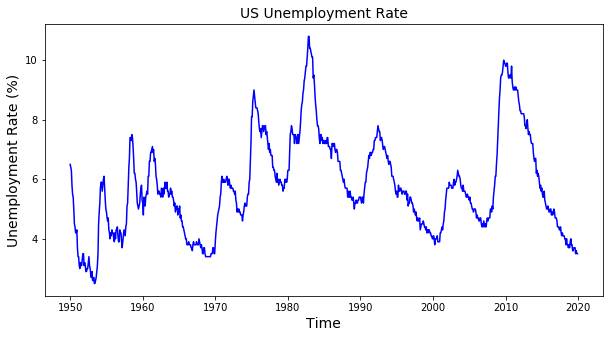

In [2]:
# Import unemployment rate data
rawData = pd.read_csv("UNRATE.csv", index_col="DATE")
rawData.index = pd.to_datetime(rawData.index)
unemp = rawData.loc[datetime(1950, 1, 1):datetime(2019, 12, 31)]

# Plot time series
plt.figure(figsize=(10, 5))
plt.plot(unemp, 'b')
plt.xlabel("Time", fontsize=14)
plt.ylabel("Unemployment Rate (%)", fontsize=14)
plt.title("US Unemployment Rate", fontsize=14)
plt.savefig('time_series_plot.png')
plt.show()

The graph above shows that unemployment rate is cyclical. It typically falls during periods of economic expansion and rises during periods of economic contraction (i.e. it follows the business cycle). We can also see that trends occurred during certain periods. For example, if we ignore its cyclical behaviour, the mean unemployment rate fell from the early-1980s to the late-2000s.

Before fitting an ARMA model to the time series (which will be denoted as $\{U_t\}$), the trend and seasonality should be removed. Here, the classical decomposition model will be used. It is given by the following expression, in which $m_t$ is the trend component, $s_t$ is the seasonal component and $Y_t$ is the residual sequence.

\begin{equation}
    U_t = m_t + s_t + Y_t
\end{equation}

The statsmodels implementation of the classical decomposition model was used. This method filters the data using a centred moving average in order to estimate and eliminate the trend and seasonal components.

**Explain method more**.

In [22]:
# statsmodels implementation of the classic decomposition model
components = seasonal_decompose(unemp, model='additive')
trend = components.trend
seasonal = components.seasonal
resid = components.resid

The code below plots the trend component, the seasonal component and the residual sequence.

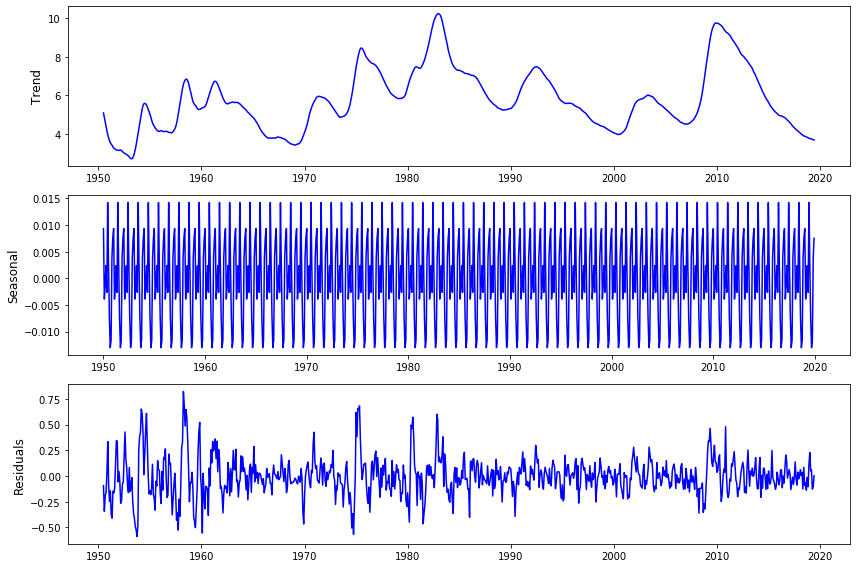

In [23]:
f, axs = plt.subplots(3, 1, figsize=(12, 8))

plt.subplot(311)
plt.plot(trend, 'b')
plt.ylabel("Trend", fontsize=12)

plt.subplot(312)
plt.plot(seasonal, 'b-')
plt.ylabel("Seasonal", fontsize=12)

plt.subplot(313)
plt.plot(resid, 'b-')
plt.ylabel("Residuals", fontsize=12)

plt.tight_layout()
plt.savefig("decomposition.png")
plt.show()

**Discuss the decomposition according to the background knowledge of the data set. Problem: method picks up shorter time period seasonality than that described above.**

**Variance of white noise in model fit.**

A time series is said to have a unit root if 1 is a root of its characteristic equation. If a linear process has a unit root, it does not have a unique stationary solution. To test whether a unit root exists in a time series, an augmented Dickey-Fuller (ADF) test can be used. The test's null hypothesis is that a unit root exists, i.e. the time series is non-stationary. The alternative hypothesis is that no unit root exists. The more negative the test statistic is, the more confidently we can reject the null. This test is implemented below using a 5% significance level.

In [5]:
resid.dropna(inplace=True)
results = adfuller(resid, regression="nc")
print(f"The p-value for the ADF test is: {results[1]:.4f}")

The p-value for the ADF test is: 0.0000


The p-value for the ADF test is smaller than the significance level, 0.05. Therefore, there is sufficient evidence to reject the null hypothesis at a 5% significance level. This suggests that the residual sequence is stationary.

The autocorrelation function (ACF) and the partial autocorrelation function (PACF) of the residual sequence are plotted below. It is important to note that the lags are in units of months.

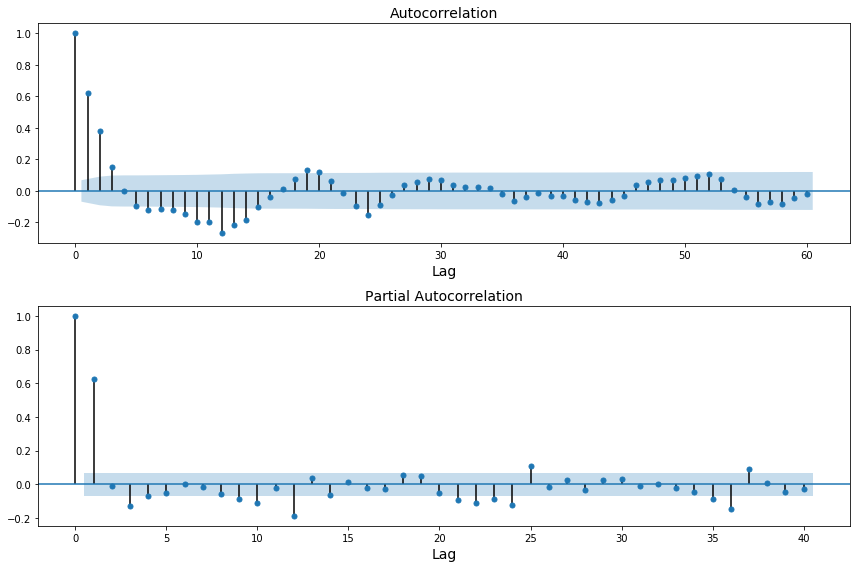

In [6]:
# Plot ACF and PACF of the residual sequence
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid, lags=60, ax=ax1)
plt.title("Autocorrelation", fontsize=14)
plt.xlabel("Lag", fontsize=14)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)
plt.title("Partial Autocorrelation", fontsize=14)
plt.xlabel("Lag", fontsize=14)

plt.tight_layout()
plt.savefig("ACF.png")
plt.show()

The ACF helps us determine whether the residuals are serially correlated. The shaded region represents the 95% confidence interval, and allows us to check if the autocorrelation is significantly non-zero. Note that, by definition, the ACF is 1 for a lag, $h$, of 0. We can see that serial correlation exists in the unemployment rate. The ACF is significantly non-zero for several lags, most notably $h=1$, $h=2$ and $h=3$. For $h=4$, the ACF is insignificant. This indicates that, when modelling the sequence, the moving-average (MA) part of the ARMA model should have an order of 3. This is because a MA model of order $q$ is $q$-correlated. Note that no serial correlation exists for a lag greater than 25.

The above method cannot be used for the autoregressive (AR) part of the ARMA model. This is because the sequence is regressed onto itself, and hence the serial correlation at a given lag affects the serial correlation for larger lags. Instead, the PACF must be used. The PACF calculates the correlation with a lagged sequence after removing the information that can be explained by intermediate realisations. The graph above shows that the PACF is significant for $h=1$, but insignificant for $h=2$. This implies that the AR part of the ARMA model should have an order of 1.

The following code fits an ARMA(1,3) model to the residual sequence and prints a summary.

In [7]:
# Fit ARMA(1,3) model
warnings.simplefilter('ignore')
arma_mod13 = ARIMA(resid, order=(1, 0, 3)).fit()
print(arma_mod13.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  828
Model:                 ARIMA(1, 0, 3)   Log Likelihood                 435.652
Date:                Sun, 17 Jan 2021   AIC                           -859.304
Time:                        22:43:30   BIC                           -830.990
Sample:                    07-01-1950   HQIC                          -848.444
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.012     -0.164      0.870      -0.027       0.022
ar.L1          0.3832      0.124      3.083      0.002       0.140       0.627
ma.L1          0.2329      0.127      1.829      0.0

Although the ACF is insignificant for $h=4$, it is significant for $h=5$ to $h=14$. Therefore, it is justifiable to increase the order of the MA part to 14. An ARMA(1,14) model is fit to the residual sequence using the code below.

In [8]:
# Fit ARMA(1,14) model
arma_mod114 = ARIMA(resid, order=(1, 0, 14)).fit()
print(arma_mod114.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  828
Model:                ARIMA(1, 0, 14)   Log Likelihood                 492.191
Date:                Sun, 17 Jan 2021   AIC                           -950.382
Time:                        22:43:35   BIC                           -870.159
Sample:                    07-01-1950   HQIC                          -919.614
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.936e-05      0.001      0.083      0.934      -0.001       0.001
ar.L1          0.4763      0.103      4.614      0.000       0.274       0.679
ma.L1          0.1027      0.159      0.648      0.5

The previous ARMA model was complex, requiring 15 coefficients to be estimated. An ARMA(1,1) model has been fit below in order to compare a complex model to a simple model, and to provide a baseline for performance.

In [9]:
# Fit ARMA(1,1) model
arma_mod11 = ARIMA(resid, order=(1, 0, 1)).fit()
print(arma_mod11.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  828
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 429.532
Date:                Sun, 17 Jan 2021   AIC                           -851.063
Time:                        22:43:35   BIC                           -832.187
Sample:                    07-01-1950   HQIC                          -843.824
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.013     -0.165      0.869      -0.028       0.024
ar.L1          0.6151      0.033     18.453      0.000       0.550       0.680
ma.L1          0.0097      0.047      0.209      0.8

To compare the three ARMA models, the Akaike information criterion (AIC) will be used. The AIC quantifies the quality of a statistical model by estimating the relative amount of information lost. It is a common method used for model selection – the best model is that with the minimum AIC value.

A key benefit of the AIC is that it takes into account the trade-off between the model's goodness of fit and its simplicity. In other words, it penalises both overfitting and underfitting. More specifically, the AIC is the sum of two terms, the first of which is the negative log-likelihood. The second uses the order of the model to quantify its complexity. 

The AIC values for the three models were as follows:

* ARMA(1,1): -851.1
* ARMA(1,3): -859.3
* ARMA(1,14): -950.4

These results indicate that the ARMA(1,14) model is preferred. We can see that, as the model becomes more complex, the AIC falls. This might indicate the presence of overfitting. However, as the AIC penalises complexity, we can be confident in choosing the ARMA(1,14) model. What's more, both the Bayesian information criterion (BIC) and the Hannan–Quinn information criterion (HQIC) are smallest for the ARMA(1,14) model. The final model is

\begin{equation}
    U_t = \phi_1 U_{t-1} + Z_t + \sum_{j=1}^{14} \theta_j Z_{t-j},
\end{equation}

where the coefficients are as follows: 

\begin{equation}
\phi_1 = 0.4763, \theta_1 = 0.1027, \theta_2 = 0.0698, \theta_3 = -0.0294, \\
\theta_4 = -0.0629 , \theta_5 = -0.1310, \theta_6 = -0.0684, \theta_7 = -0.0521, \\
\theta_8 = 0.0088, \theta_9 = -0.0161, \theta_{10} = -0.1505 , \theta_{11} = -0.0404, \\
\theta_{12} = -0.3800 , \theta_{13} = -0.0862 , \theta_{14} = -0.1609.
\end{equation}

### 3. Financial Data

In this section, a company's stock price data will be analysed. The purpose is to appreciate the benefits of log returns over simple returns and to understand the stylised facts of financial data.

The company chosen was Microsoft (MSFT) and the period chosen was 04/01/2016 to 04/01/2020 inclusive. The following code plots the stock price against time. Note that the frequency is daily.

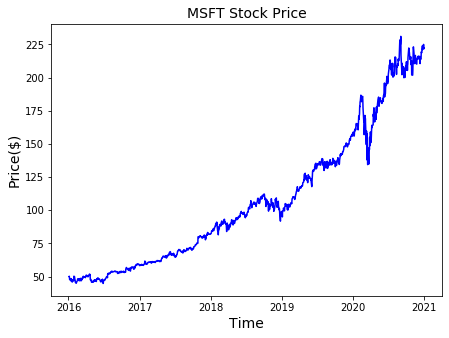

In [10]:
# Import MSFT data
msft = pd.read_csv('MSFT_Daily.csv', index_col='Date')
msft.index = pd.to_datetime(msft.index)

# Plot price against time
plt.figure(figsize=(7, 5))
plt.plot(msft['Adj Close'], 'b')
plt.xlabel("Time", fontsize=14)
plt.ylabel("Price($)", fontsize=14)
plt.title("MSFT Stock Price", fontsize=14)
plt.savefig("financial_plot.png")
plt.show()

### 3.1. Log Returns

In practice, return data is preferred to price data as it is more informative (it is scale-free, for example) and has more attractive mathematical properties. The gross $k$-period simple return ($1+R_t[k]$) is defined as follows:

\begin{equation}
  1+R_t[k] = \frac{P_t}{P_{t-k}},
\end{equation}

where $P_t$ is the price at time $t$. Note that $R_t[k]$ is referred to as the net $k$-period simple return. 

An alternative to the $k$-period simple return is the $k$-period log return, $r_t[k]$, which is defined as follows:

\begin{equation}
  r_t = \log{(1 + R_t[k])} = \log{(P_t)} - \log{(P_{t-k})}.
\end{equation}

Log returns are preferred to simple returns for two reasons, the first of which is that the statistical properties of log returns are more tractable. The second is that the $k$-period log return is the sum of $k$ 1-period log returns, as shown below:

\begin{equation}
  r_t = \log{(1 + R_t[k])} = \log{(P_t)} - \log{(P_{t-k})} = \sum_{j=0}^{k-1} r_{t-j}.
\end{equation}

The corresponding expression for simple returns is

\begin{equation}
  R_t[k] = [\prod_{j=0}^{k-1} (1+R_{t-j})] - 1,
\end{equation}

which is more complicated.

The following code plots a graph that compares Microsoft's log returns with its simple returns over a 100-day period at the start of 2016. 

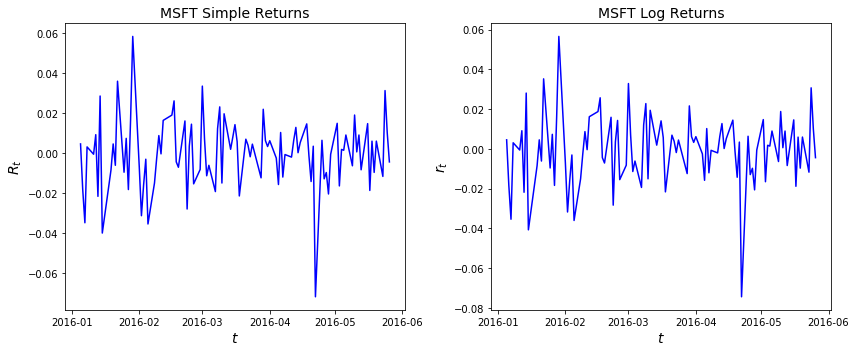

In [11]:
# Calculate (net) simple returns
returns = msft['Adj Close'].pct_change()
returns.index = msft.index
returns.dropna(inplace=True)

# Calculate log returns
log_returns = pd.Series(data=np.log(1+returns), index=returns.index)

# Plot simple and log returns against time
f, axs = plt.subplots(1, 2, figsize=(12, 5))

plt.subplot(121)
plt.plot(returns[:100], 'b')
plt.xlabel("$t$", fontsize=14)
plt.ylabel("$R_t$", fontsize=14)
plt.title("MSFT Simple Returns", fontsize=14)

plt.subplot(122)
plt.plot(log_returns[:100], 'b-')
plt.xlabel("$t$", fontsize=14)
plt.ylabel("$r_t$", fontsize=14)
plt.title("MSFT Log Returns", fontsize=14)

plt.tight_layout()
plt.savefig("returns_plot.png")
plt.show()

The similarity of the plots above illustrates an important property of log returns, namely that $r_t \approx R_t$ if $R_t$ is small. Therefore, we can benefit from the useful mathematical properties of log returns without significantly altering the data.

### 3.2. Stylised Facts of Financial Data

There are several common features of financial time series. These are the so-called 'stylised facts'. The first is that observations are uncorrelated, i.e. log returns have no significant serial correlation. The ACF of Microsoft's log returns has been plotted to investigate this.

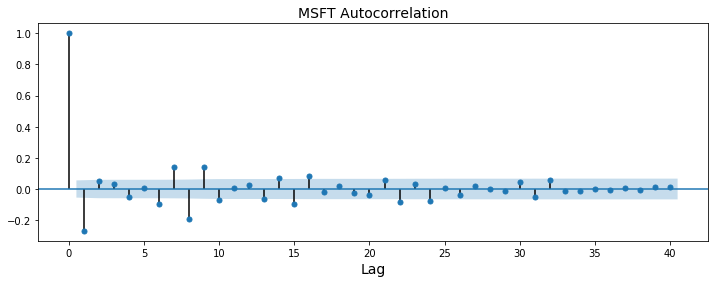

In [12]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(111)
fig = sm.graphics.tsa.plot_acf(log_returns, lags=40, ax=ax1)
plt.xlabel("Lag", fontsize=14)
plt.title("MSFT Autocorrelation", fontsize=14)
plt.savefig("MSFT_ACF.png")
plt.show()

We can see that the autocorrelation is significant for a few lags. For example, the autocorrelation function for a lag of 1 is greater than 0.2 in magnitude. This indicates that an increase in returns is typically followed by a decrease in returns the following day, and vice versa. Such 'mean-reversion' effects are commonly exploited by practitioners. That being said, the correlation is weak and ceases to be significant as lag increases, providing evidence for the first stylised fact.

The second stylised fact is 'clustered volatility', which, loosely speaking, is a phenomenon in which large variances are followed by large variances and small variances are followed by small variances. To investigate this effect, the sequence of squared log returns has been plotted below, along with its ACF.

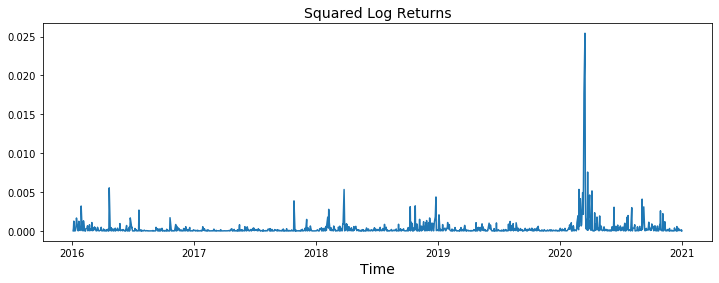

In [13]:
# Plot squared log returns
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(111)
plt.plot(log_returns**2)
plt.xlabel("Time", fontsize=14)
plt.title("Squared Log Returns", fontsize=14)
plt.savefig("squared.png")
plt.show()

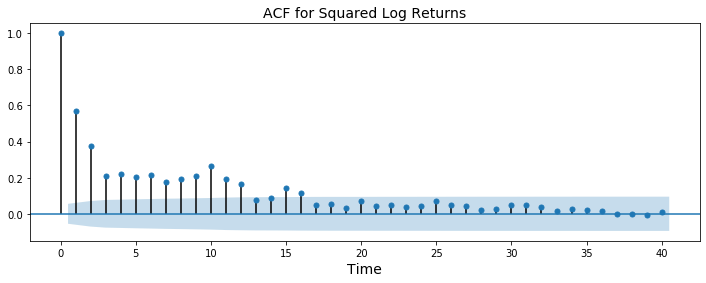

In [14]:
# Plot the ACF for squared log returns
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(111)
fig = sm.graphics.tsa.plot_acf(log_returns**2, lags=40, ax=ax1)
plt.xlabel("Time", fontsize=14)
plt.title("ACF for Squared Log Returns", fontsize=14)
plt.savefig("squared_ACF.png")
plt.show()

Squared log return is indicative of the variance because variance is the expected value of the squared deviations. In the first graph, we can see that large values do indeed 'cluster'. The same applies for small values. For example, after the peak in early-2020, the squared log return remained high for the rest of the year. The second graph provides further evidence for clustered volatility, as it shows that squared log returns are significantly and positively correlated up to a lag of approximately 15 days.

The next stylised fact of financial data is heavy tail behaviours. In other words, extreme values are more likely than they are under the normal distribution. If this is true in the case of MSFT, the distribution of log returns should have a kurtosis greater than that of the normal distribution (i.e. > 3).

In [15]:
print(f"The sample kurtosis for log returns is {robust_kurtosis(log_returns)[0]:.2f}, which is much larger than that of the normal distribution.")

The sample kurtosis for log returns is 11.43, which is much larger than that of the normal distribution.


We can also check for heavy tails graphically, using a Q-Q plot. The Q-Q plot below shows that the distribution does indeed have heavy tails, as the largest and smallest sample quantiles are greater in magnitude than the corresponding normal quantiles. 

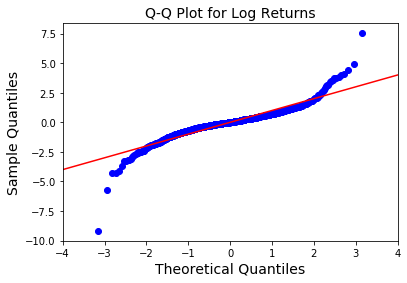

In [16]:
# Q-Q plot to check for kurtosis
fig = sm.qqplot((log_returns-np.mean(log_returns))/np.std(log_returns), stats.norm, line="45")
plt.xlim([-4, 4])
plt.xlabel("Theoretical Quantiles", fontsize=14)
plt.ylabel("Sample Quantiles", fontsize=14)
plt.title("Q-Q Plot for Log Returns", fontsize=14)
plt.savefig("qq_kurt.png")
plt.show()

The final feature of financial data is asymmetry – it is typical for log return data to be negatively skewed (i.e. to have longer negative tails than the normal distribution). One way of checking this is to calculate the sample skewness.

In [17]:
print(f"The sample skewness for log returns is {robust_skewness(log_returns)[0]:.2f}, which is indeed negative.")

The sample skewness for log returns is -0.37, which is indeed negative.


The skewness can be visualised by plotting a histogram of log returns, as is done below. We can see that the negative tail of the distribution is slightly longer than the positive tail.

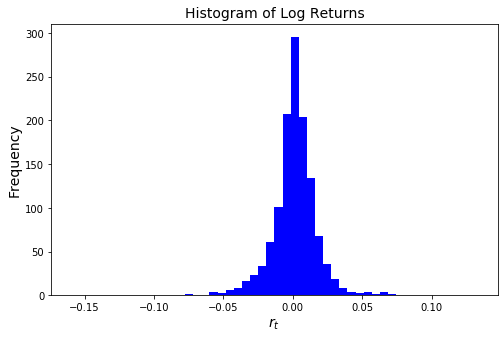

In [18]:
# Plot histogram of log returns
fig = plt.figure(figsize=(8, 5))
plt.hist(log_returns, bins=50, color='b')
plt.title("Histogram of Log Returns", fontsize=14)
plt.xlabel("$r_t$", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.savefig("hist_skew.png")
plt.show()

As for kurtosis, the skewness can be checked graphically using a Q-Q plot. The Q-Q plot below shows that the distribution has a small negative skew, as the largest two quantiles of the negative realisations are greater than those of the positive realisations.

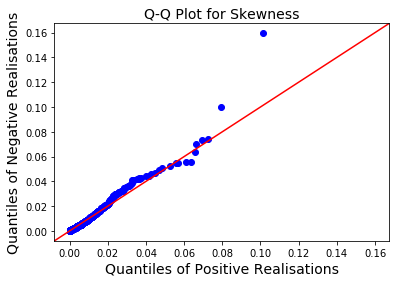

In [19]:
# Q-Q plot to check skewness
pos = abs(log_returns[log_returns >= 0])
neg = abs(log_returns[log_returns < 0])
qqplot_2samples(neg, pos, line="45")
plt.xlabel("Quantiles of Positive Realisations", fontsize=14)
plt.ylabel("Quantiles of Negative Realisations", fontsize=14)
plt.title("Q-Q Plot for Skewness", fontsize=14)
plt.savefig("qq_skew.png")
plt.show()